In [1]:
# Beware:  Installation of the ocelot code is necessary to run this notebook
# https://github.com/ocelot-collab/ocelot

# switch of warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math
import numpy as np
import matplotlib.pyplot as plt

from utils import *

# import sis18_cell as slices model, ocelot input file
from sis18_cell_slice import ring as sequence


Using TensorFlow backend.


initializing ocelot...


In [2]:
import pickle
import keras
from keras.models import Sequential, Model

import sys
from pathlib import Path
sys.path[0] = str(Path(sys.path[0]).parent.parent)

from tm_pnn.layers.Taylor_Map import TaylorMap


In [3]:
# import ocelot form benchmark
from ocelot import *
from ocelot.cpbd.optics import *
from ocelot.gui.accelerator import *
method = MethodTM()
method.global_method = SecondTM
lattice = MagneticLattice(sequence,  method=method)

tw = twiss(lattice)

In [4]:
# get TN-PNN model, input tranport matrix
# for twiss tracking at the moment, only frist ordner is used
def get_sequential_model(plane):
    if plane == 'D':
        dim = 2 # matrix dim
    else:
        dim = 3
    order = 1 # first ordner
    model = Sequential()
    lengths = []
    for i, (R, T, name, length) in enumerate(get_transfermaps(dim=6)):
        Rx, Ry, RD, yD = twiss_transport_matrix(R)
        
        # horizontal
        if plane == 'x':
            M = Rx
            y = np.zeros((1,dim))
        # vertical    
        if plane == 'y':
            M = Ry
            y = np.zeros((1,dim))
        # dispersion
        if plane == 'D':
            M = RD
            y = np.zeros((1,dim))
            y[0][0] = yD[0]
            y[0][1] = yD[1]
        # build TaylorMap, 
        # File tm_pnn.layers -> Taylor_Map -> TaylorMap
        element_map = TaylorMap(output_dim = dim, order = order, input_shape = (dim,),
                            weights=[y, M.T],
                            weights_regularizer=lambda W: sympl_reg(0.009, W))
        element_map.tag = name
    
        model.add(element_map)
        
        lengths.append(length)
        
    lengths = np.cumsum(np.array(lengths))
        
    return model, lengths

# get output of each layer (twiss parameter or par. coordinates),
# an additional element like bmp is not requried
def get_elementwise_model(plane):
    model, lengths = get_sequential_model(plane)
    model = Model(inputs=model.input, outputs=[el.output for el in model.layers])
    return model, lengths
   
# get transport matrix form ocelot code, can be replaced if necessary or requested
def get_transfermaps(dim = 2):
    method = MethodTM()
    method.global_method = SecondTM

    
    lattice = MagneticLattice(sequence,  method=method)
    for i, tm in enumerate(get_map(lattice, lattice.totalLen, Navigator(lattice))):
        R = tm.r_z_no_tilt(tm.length, 0) [:dim, :dim]
        T = tm.t_mat_z_e(tm.length, 0)[:dim, :dim, :dim].reshape((dim, -1))
        yield R, T, type(lattice.sequence[i]).__name__, lattice.sequence[i].l
        
# build twiss transport matrix from tranpsport matrix
# Lee, S. Y. (1999). Accelerator Physics. World Scientific. page 45
# the ocelot code porivde up to second ordner tranport matices
def twiss_transport_matrix(M):
    Rx = np.zeros((3,3))
    Rx[0,0] = M[0,0]**2; Rx[0,1] = -2.0*M[0,0]*M[0,1]; Rx[0,2] = M[0,1]**2
    Rx[1,0] = -M[0,0]*M[1,0]; Rx[1,1] = (M[0,0]*M[1,1] + M[0,1]*M[1,0]); Rx[1,2] = -M[1,1]*M[0,1]
    Rx[2,0] = M[1,0]**2; Rx[2,1] = -2.0*M[1,1]*M[1,0]; Rx[2,2] = M[1,1]**2
        
    Ry = np.zeros((3,3))
    Ry[0,0] = M[2,2]**2; Ry[0,1] = -2.0*M[2,2]*M[2,3]; Ry[0,2] = M[2,3]**2
    Ry[1,0] = -M[2,2]*M[3,2]; Ry[1,1] = (M[2,2]*M[3,3]+M[2,3]*M[3,2]); Ry[1,2] = -M[3,3]*M[2,3]
    Ry[2,0] = M[3,2]**2; Ry[2,1] = -2.0*M[3,3]*M[3,2]; Ry[2,2] = M[3,3]**2
    
    RD = np.zeros((2,2))
    RD[0,0] = M[0,0]; RD[0,1] = M[0,1]
    RD[1,0] = M[1,0]; RD[1,1] = M[1,1]
    
    yD = np.array([M[0,5], M[1,5]])
    
    return Rx, Ry, RD, yD


In [5]:
# build TN-PNN model
twiss_mlx, lengths = get_elementwise_model(plane='x')
twiss_mly, lengths = get_elementwise_model(plane='y')
twiss_mlD, lengths = get_elementwise_model(plane='D')

In [6]:
# get lattice function from ocelot,
beta_x = [p.beta_x for p in tw] 
alpha_x = [p.alpha_x for p in tw] 
beta_y = [p.beta_y for p in tw] 
alpha_y = [p.alpha_y for p in tw] 
Dx = [p.Dx for p in tw] 
Dpx = [p.Dxp  for p in tw] 

# input twiss b0, a0, D0 for TM-PNN, 
twx_ml = np.array([beta_x[0], alpha_x[0], (1.0+alpha_x[0]**2)/beta_x[0]]).reshape(1, -1)
twy_ml = np.array([beta_y[0], alpha_y[0], (1.0+alpha_y[0]**2)/beta_y[0]]).reshape(1, -1)
twD_ml = np.array([Dx[0], Dpx[0]]).reshape(1, -1)

In [7]:
# twiss predict with TM-PNN with output at each layer
twx_ml_train = np.array(twiss_mlx.predict(twx_ml))[:, 0, :]
twy_ml_train = np.array(twiss_mly.predict(twy_ml))[:, 0, :]
twD_ml_train = np.array(twiss_mlD.predict(twD_ml))[:, 0, :]

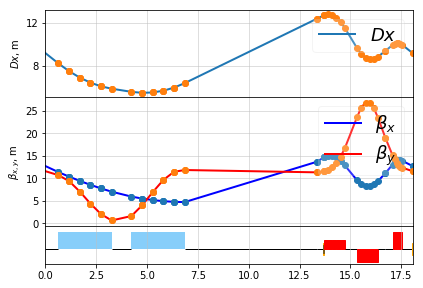

In [8]:
# plot lattice function from ocelot
plot_opt_func(lattice,tw, legend=False)
cur_fig = plt.gcf()
cur_axes = plt.gca()
ax0=cur_fig.axes[0]
ax1=cur_fig.axes[1]

# plot TM-PNN lattice function
ax0.plot(lengths,twD_ml_train[:, 0], 'o')
ax1.plot(lengths,twx_ml_train[:, 0], 'o')
ax1.plot(lengths,twy_ml_train[:, 0], 'o')